In [6]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

from itertools import combinations

# fetch dataset 
abalone = fetch_ucirepo(id=1) 

X = abalone.data.features 
y = abalone.data.targets 


In [36]:
X.shape, y.shape

((4177, 8), (4177, 1))

In [37]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Length               Axes(0.125,0.798085;0.168478x0.0819149)
Diameter          Axes(0.327174,0.798085;0.168478x0.0819149)
Height            Axes(0.529348,0.798085;0.168478x0.0819149)
Whole_weight      Axes(0.731522,0.798085;0.168478x0.0819149)
Shucked_weight       Axes(0.125,0.699787;0.168478x0.0819149)
Viscera_weight    Axes(0.327174,0.699787;0.168478x0.0819149)
Shell_weight      Axes(0.529348,0.699787;0.168478x0.0819149)
dtype: object

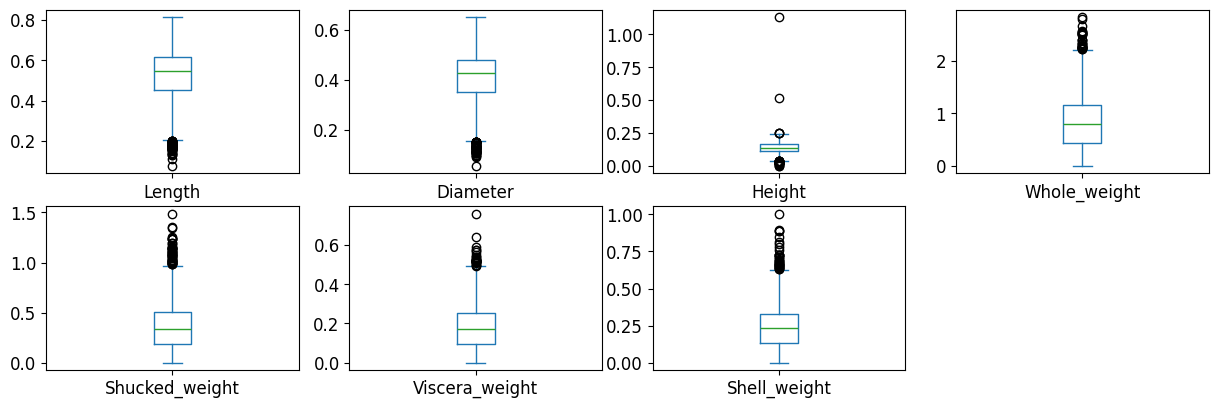

In [40]:
data_mean = X.iloc[:, :] 
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False,
sharey=False, fontsize=12, figsize=(15,20))

In [41]:
le = LabelEncoder()
data_mean['Sex'] = le.fit_transform(data_mean['Sex']) # Male = 2, Female = 0, Infant = 1
data_mean.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [42]:
# Check for empty data entries
data_mean.isnull().sum()

# Check for outliers in each feature
for column in data_mean.columns:
    Q1 = data_mean[column].quantile(0.25)
    Q3 = data_mean[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data_mean[column] < (Q1 - 2 * IQR)) | (data_mean[column] > (Q3 + 2 * IQR))).sum()
    print(f'{column}: {outliers} outliers')

Sex: 0 outliers
Length: 2 outliers
Diameter: 1 outliers
Height: 5 outliers
Whole_weight: 3 outliers
Shucked_weight: 16 outliers
Viscera_weight: 5 outliers
Shell_weight: 9 outliers


<Axes: >

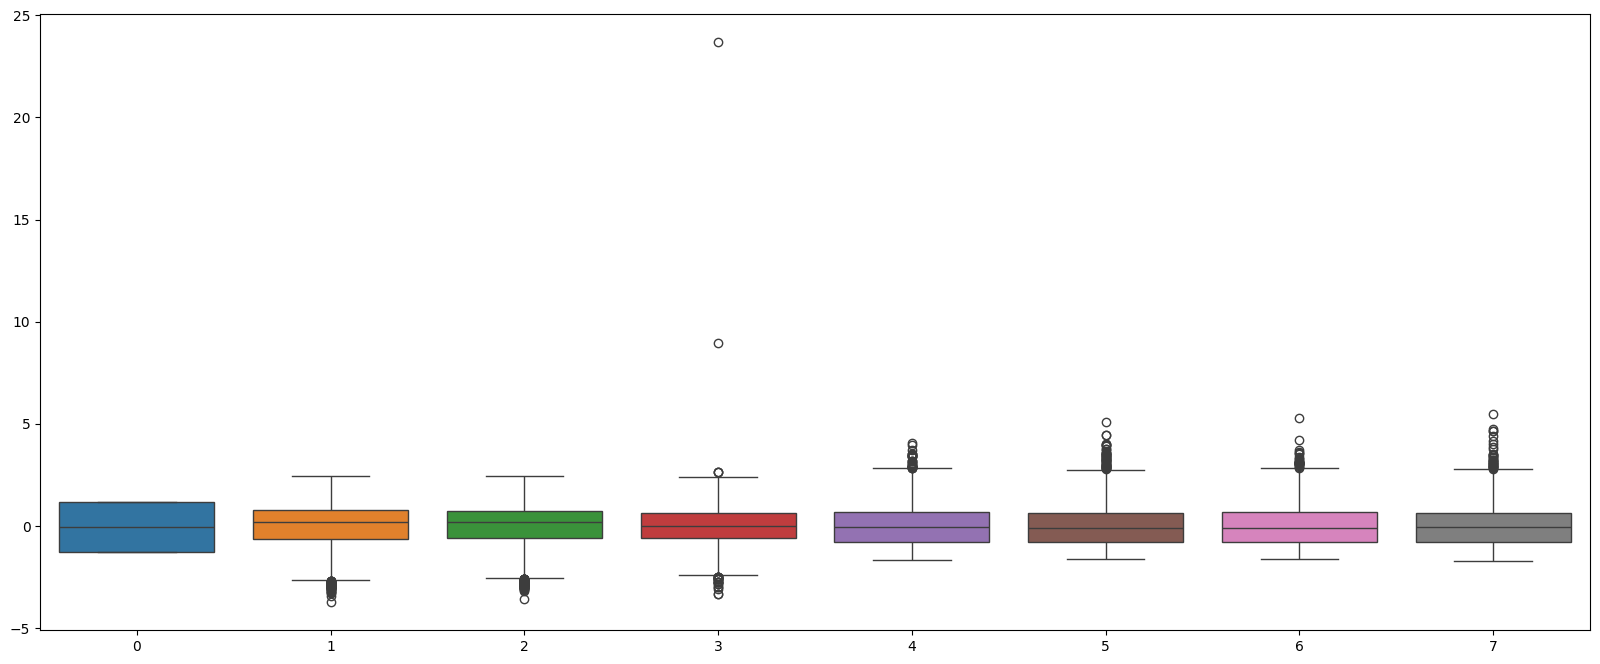

In [43]:
scaler = StandardScaler()
Xs = scaler.fit_transform(data_mean)

# Print features normalised (Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=Xs,ax=ax)

In [44]:
data_mean.shape

(4177, 8)

### Linear Regression: No Kfold

In [45]:
from sklearn.linear_model import LinearRegression

## Linear regression

# Create linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(data_mean, y)

# Print the coefficients
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Predict the target values
y_pred = lr.predict(data_mean)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[  0.06368262  -1.57721493  13.42050382  11.8643924    9.25049011
  -20.28094179  -9.76109706   8.5805683 ]]
Intercept: [2.89935859]
Mean Squared Error: 4.906524345190111
R^2 Score: 0.5278909357356787


### Linear Regression: With K-Fold Cross Validation (No hyperparameter tuning)

In [46]:
from sklearn.model_selection import KFold, cross_val_score

lr = LinearRegression()

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(lr, data_mean, y, scoring="neg_mean_squared_error", cv=kf)

scores*-1 # Turn MSEs to thei true positive values

# Print the cross-validation scores
print("Cross-validation MSE scores:", -scores)
print("Mean MSE:", -scores.mean())
print("Standard Deviation of MSE:", scores.std())

Cross-validation MSE scores: [4.90324016 5.67146225 4.96773481 5.24396043 4.48616295]
Mean MSE: 5.054512117387684
Standard Deviation of MSE: 0.39241621038130514


### Linear Regression: K-Fold Cross Validation with HyperParameter Tuning
#### Hyperparameter = Feature Selection

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Function to perform forward feature selection
def forward_feature_selection(X, y, kf):
    n_features = X.shape[1]
    best_features = []
    best_score = float('inf')

    for i in range(1, n_features + 1): # i = length of each possible combination
        feature_combinations = combinations(range(n_features), i) # All possible combinations of features with length i 
        for combination in feature_combinations:
            scores = []
            for train_index_ffs, val_index in kf.split(X):
                X_train_ffs, X_val = X.iloc[train_index_ffs, list(combination)], X.iloc[val_index, list(combination)]
                y_train_ffs, y_val = y.iloc[train_index_ffs], y.iloc[val_index]

                model = LinearRegression()
                model.fit(X_train_ffs, y_train_ffs)
                y_pred_ffs = model.predict(X_val)
                scores.append(mean_squared_error(y_val, y_pred_ffs))

            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_features = combination

    return best_features, best_score



# Perform k-fold cross-validation with forward feature selection
final_scores = []
best_feature_combinations = []

for train_index, test_index in kf.split(data_mean):
    X_train, X_test = data_mean.iloc[train_index], data_mean.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_features, _ = forward_feature_selection(X_train, y_train, KFold(n_splits=5, shuffle=True, random_state=1))
    best_feature_combinations.append(best_features)
    model = LinearRegression()

    model.fit(X_train.iloc[:, list(best_features)], y_train) # Fit model using best features
    y_pred = model.predict(X_test.iloc[:, list(best_features)]) # Get model predicted values # TODO: CHECK IF WE USE X_test HERE
    final_scores.append(mean_squared_error(y_test, y_pred)) # Compare to test set 

    print(f"Completed fold with best features: {best_features}")

# Convert final_scores to a numpy array and negate the scores
final_scores = -np.array(final_scores)

# Print the cross-validation scores
print("Cross-validation MSE scores for each fold:")
for i, scores in enumerate(final_scores):
    print(f"Fold {i+1}: {scores}")

print("Mean MSE:", final_scores.mean())

# # Print the best feature combinations for each fold
# print("Best feature combinations for each fold:")
# for i, features in enumerate(best_feature_combinations):
#     print(f"Fold {i+1}: {features}")

Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (0, 2, 3, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
Cross-validation MSE scores for each fold:
Fold 1: -4.995438038300506
Fold 2: -5.653149684534355
Fold 3: -5.086942888816689
Fold 4: -5.335430480025445
Fold 5: -4.5634513752877
Mean MSE: -5.126882493392939


### Linear Regression on resulting features from hyperparameter tuning


In [48]:
# Best features: Diameter, all weights

selected_features = [2,4,5,6,7]

data_mean_selected = data_mean.iloc[:, selected_features]

lr = LinearRegression()

lr.fit(data_mean_selected, y)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

y_pred = lr.predict(data_mean_selected)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[ 14.02804515   9.36851129 -20.48015938  -9.4179386    9.50551122]]
Intercept: [3.23834107]
Mean Squared Error: 4.978455837925833
R^2 Score: 0.5209696392460592
